In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

Our data source is the [mammal population density dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.m63xsj40d) used by Tucker et al. for a [recent Ecography article](https://onlinelibrary.wiley.com/doi/10.1111/ecog.05126).  It contains information for 468 mammalian species, including data on their density in each location, Human Footprint index (a global proxy of human direct and indirect disturbances), Landsat Normalized Difference Vegetation Index (NDVI), and other parameters for the time period between 1990-2018.  We initially took a subset of six species of interest: Canis latrans (coyote), Canis lupus (wolf), Meles meles (European badger), Procyon lotor (raccoon), Semnopithecus entellus (gray langur), and Vulpes vulpes (red fox), for a total of 217 data points.

In [4]:
urban = pd.read_csv('urbananimals4.csv')

In [5]:
urban.sample(5)

,Unnamed: 0,Species,Order,Family,Year,Longitude,Latitude,Site,Country,Density (Ind/km2),...,NDVI_10km,Species Richness_10km,Accessibility_10kmBuff,Human Footprint_10kmBuff,Night Lights_10kmBuff,Cropland_10kmBuff,Pasture_10kmBuff,Human Population Density_10kmBuff,NDVI_10kmBuff,Species Richness_10kmBuff
172,3904,Vulpes vulpes,Carnivora,Canidae,2000,52.450,16.950,Near Poznan,Poland,1.790,...,0.145,25.243,1003.000,0.264,0.000,0.000,0.000,0.235,0.145,25.243
9,157,Semnopithecus entellus,Primates,Cercopithecidae,1990,76.400,27.233,Sariska Tiger reserve,India,30.000,...,0.417,57.284,166.188,15.884,4.124,55.003,0.000,270.302,0.406,57.064
82,2751,Semnopithecus entellus,Primates,Cercopithecidae,1996,76.130,12.100,Arkeri,India,4.100,...,0.664,76.861,200.500,10.701,0.752,20.060,1.122,169.073,0.663,76.483
116,3061,Meles meles,Carnivora,Mustelidae,1997,16.600,49.200,Brno – město District,Czech Republic,0.437,...,0.486,65.935,NaN,NaN,47.634,NaN,NaN,NaN,NaN,NaN
27,830,Canis latrans,Carnivora,Canidae,1993,-138.083,60.971,Kluane Lake (Yukon),Canada,0.014,...,0.316,41.782,1101.000,NaN,0.000,0.000,0.000,0.024,0.316,41.782


There were some missing values, but these primarily occurred in columns which seemed to be providing additional details to the complete data, so we did a quick cleanup of the data by simply dropping any columns containing null values.

In [6]:
urban_clean = urban.dropna(axis=1)

In [7]:
urban_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     217 non-null    int64  
 1   Species                        217 non-null    object 
 2   Order                          217 non-null    object 
 3   Family                         217 non-null    object 
 4   Year                           217 non-null    int64  
 5   Longitude                      217 non-null    float64
 6   Latitude                       217 non-null    float64
 7   Country                        217 non-null    object 
 8   Density (Ind/km2)              217 non-null    float64
 9   Mass (g)                       217 non-null    float64
 10  Diet                           217 non-null    object 
 11  Continent                      217 non-null    object 
 12  Human Footprint_1deg           217 non-null    flo

In [8]:
for x in urban_clean.Species.unique():
    print(x,urban_clean['Species'].str.contains(x).value_counts()[True])

Canis latrans 14
Canis lupus 20
Meles meles 76
Procyon lotor 37
Semnopithecus entellus 16
Vulpes vulpes 54


To begin exploratory data anaylsis, we created some plots to look for a correlation between some of the features of interest, including species density and related features, human density and related features, and environmental characteristics.

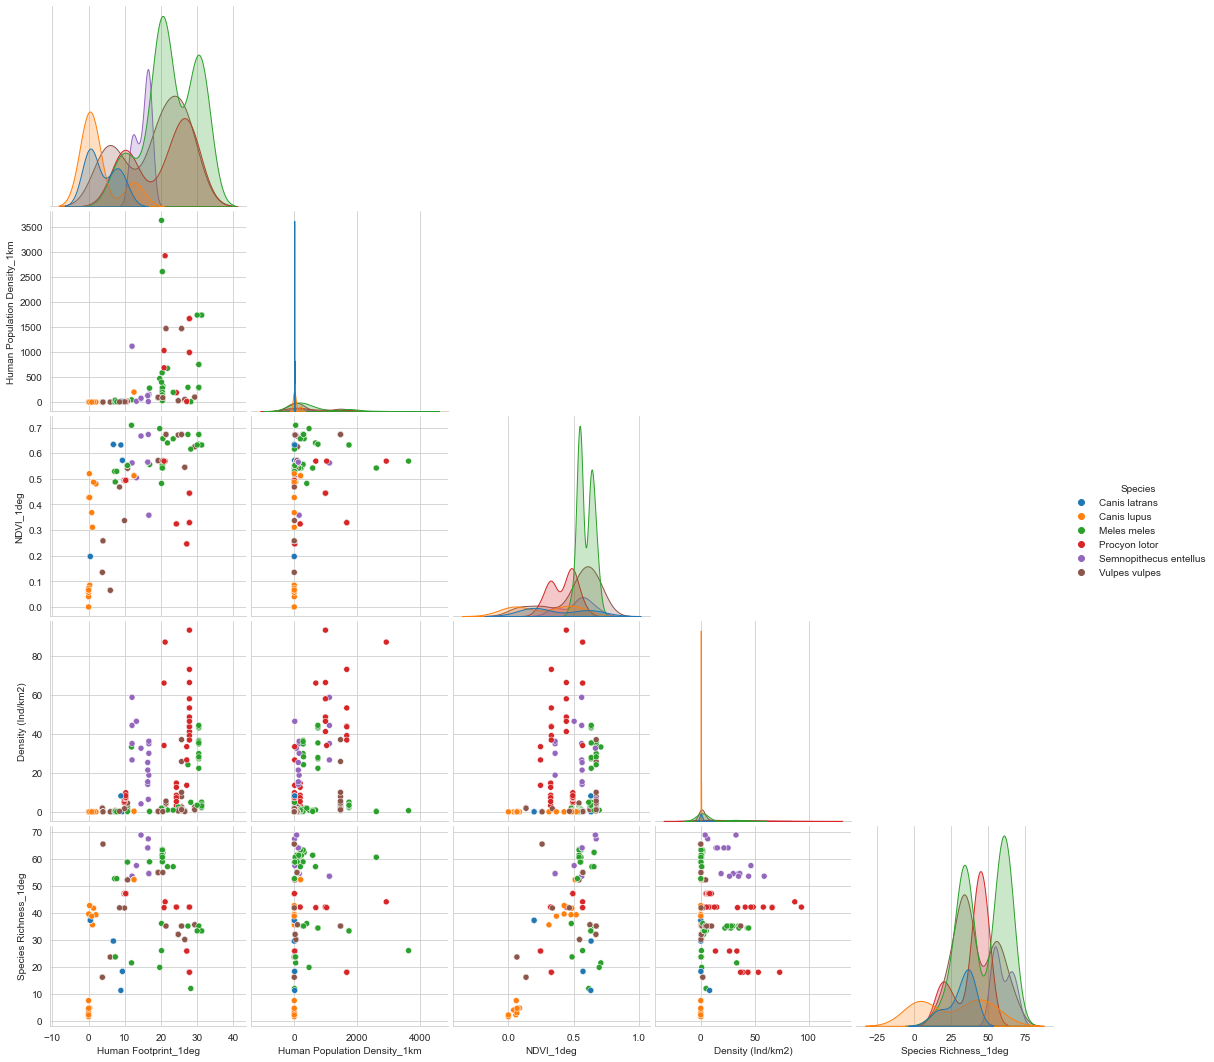

In [ ]:
sns.pairplot(urban_clean,
                hue = 'Species',
                y_vars = ['Human Footprint_1deg','Human Population Density_1km','NDVI_1deg','Density (Ind/km2)','Species Richness_1deg'],
                x_vars = ['Human Footprint_1deg','Human Population Density_1km','NDVI_1deg','Density (Ind/km2)','Species Richness_1deg'],
                height = 3,
                corner = True)

plt.show()

This initial exploration revealed that most of the data points were for observations in areas of low human population density, so it was difficult to discern a correlation between human activity and species density.  (Based on the paper from which these data were obtained, there is a positive correlation between the two, so this was not our primary focus.)  We were hoping to be able to predict species density using some of the environmental features, such as NDVI and Species Richness.  Upon further investigation, the data for Species Richness at 10km were identical to those at 50km; given that the NDVI data was different for 10km/50km/1deg, and we didn't know whether the Species Richness data being identical across two columns was an error, it made sense to stick with 1-degree data for both features.

Moreover, we noted the following comments in the data source article: ''The positive relationship between population density and HFI we reveal here was robust against various potential biases in the data that we accounted for (e.g. sampling). However, there are other potential correlates of HFI that may positively influence mammal population densities that we could not account for here, such as difficult to measure covariates like freshwater availability. It is also possible that the effect of humans on mammal population density may relate to a potential overlap between the environmental preferences of humans and mammals, where humans and mammals prefer to colonise areas with favourable characteristics, such as adequate resource availability and mild climatic conditions, could provide additional explanation for the positive relationship between density and the HFI. With the inclusion of NDVI in our models, we should have accounted for at least some of the impacts of resource availability.''  

So, focusing on NDVI to predict species density seemed to be worth a try.  To avoid being mislead by differences in species behavior, we separated the six species of interest into separate data frames and looked for correlations with NDVI.

In [9]:
coyote_data = urban_clean.loc[urban_clean['Species'].str.contains('Canis latrans')]
wolf_data = urban_clean.loc[urban_clean['Species'].str.contains('Canis lupus')]
badger_data = urban_clean.loc[urban_clean['Species'].str.contains('Meles meles')]
raccoon_data = urban_clean.loc[urban_clean['Species'].str.contains('Procyon lotor')]
langur_data = urban_clean.loc[urban_clean['Species'].str.contains('Semnopithecus entellus')]
fox_data = urban_clean.loc[urban_clean['Species'].str.contains('Vulpes vulpes')]

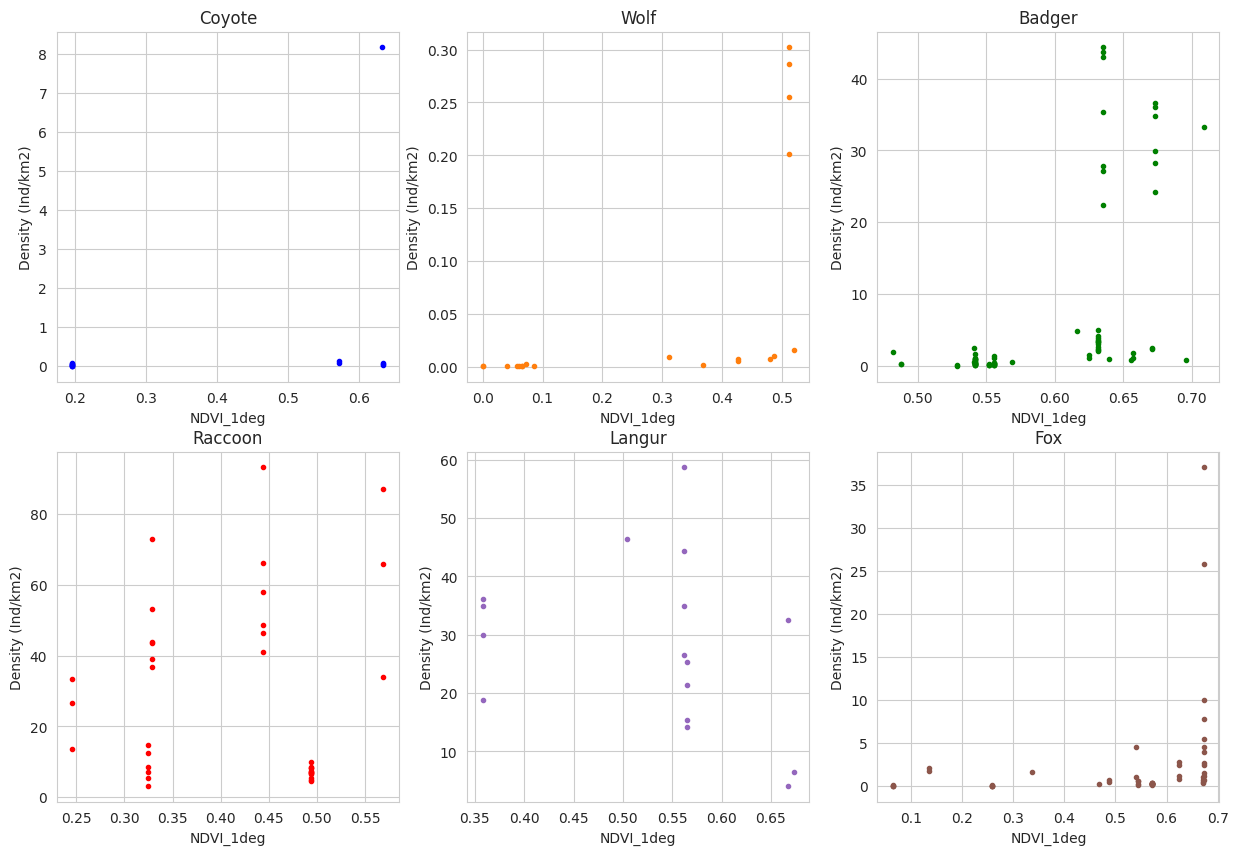

In [10]:
fig,axes = plt.subplots(2,3,figsize=(15,10))

axes[0,0].plot(coyote_data['NDVI_1deg'],coyote_data['Density (Ind/km2)'],'b.')
axes[0,0].set_xlabel('NDVI_1deg', fontsize=10)
axes[0,0].set_ylabel('Density (Ind/km2)', fontsize=10)
axes[0,0].set_title('Coyote', fontsize=12)

axes[0,1].plot(wolf_data['NDVI_1deg'],wolf_data['Density (Ind/km2)'],color='tab:orange',marker='.',linewidth=0)
axes[0,1].set_xlabel('NDVI_1deg', fontsize=10)
axes[0,1].set_ylabel('Density (Ind/km2)', fontsize=10)
axes[0,1].set_title('Wolf', fontsize=12)

axes[0,2].plot(badger_data['NDVI_1deg'],badger_data['Density (Ind/km2)'],'g.')
axes[0,2].set_xlabel('NDVI_1deg', fontsize=10)
axes[0,2].set_ylabel('Density (Ind/km2)', fontsize=10)
axes[0,2].set_title('Badger', fontsize=12)

axes[1,0].plot(raccoon_data['NDVI_1deg'],raccoon_data['Density (Ind/km2)'],'r.')
axes[1,0].set_xlabel('NDVI_1deg', fontsize=10)
axes[1,0].set_ylabel('Density (Ind/km2)', fontsize=10)
axes[1,0].set_title('Raccoon', fontsize=12)

axes[1,1].plot(langur_data['NDVI_1deg'],langur_data['Density (Ind/km2)'],color='tab:purple',marker='.',linewidth=0)
axes[1,1].set_xlabel('NDVI_1deg', fontsize=10)
axes[1,1].set_ylabel('Density (Ind/km2)', fontsize=10)
axes[1,1].set_title('Langur', fontsize=12)

axes[1,2].plot(fox_data['NDVI_1deg'],fox_data['Density (Ind/km2)'],color='tab:brown',marker='.',linewidth=0)
axes[1,2].set_xlabel('NDVI_1deg', fontsize=10)
axes[1,2].set_ylabel('Density (Ind/km2)', fontsize=10)
axes[1,2].set_title('Fox', fontsize=12)

plt.show()

Separating the data by species, it is unclear whether they are all correlated with NDVI, and in general there aren't enough data points to be able to make any reasonable predictions.  Still, we fit some simple linear regression models just to check; in particular, we were interested in whether the NDVI models would outperform the Human Footprint models.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from sklearn.model_selection import KFold

In [14]:
kfold = KFold(5,
              shuffle = True,
              random_state = 919)

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [16]:
def critter_test(critter_data):

    critter_train, critter_test = train_test_split(critter_data.copy(),
                                        random_state = 919,
                                        shuffle = True,
                                        test_size=.2)

    mses = np.zeros((4, 5))
    i = 0
    for train_index, test_index in kfold.split(critter_train):
        critter_t_t = critter_train.iloc[train_index]
        critter_ho = critter_train.iloc[test_index]
    
        pred0 = critter_t_t['Density (Ind/km2)'].mean() * np.ones(len(critter_ho))
    
        model1 = LinearRegression(copy_X=True)
        model1.fit(critter_t_t['NDVI_1deg'].values.reshape(-1,1), critter_t_t['Density (Ind/km2)'].values)
        pred1 = model1.predict(critter_ho['NDVI_1deg'].values.reshape(-1,1))
    
        model2 = LinearRegression(copy_X=True)
        model2.fit(critter_t_t['Human Footprint_1deg'].values.reshape(-1,1), critter_t_t['Density (Ind/km2)'].values)
        pred2 = model2.predict(critter_ho['Human Footprint_1deg'].values.reshape(-1,1))

        model3 = LinearRegression(copy_X=True)
        model3.fit(critter_t_t['Species Richness_1deg'].values.reshape(-1,1), critter_t_t['Density (Ind/km2)'].values)
        pred3 = model3.predict(critter_ho['Species Richness_1deg'].values.reshape(-1,1))

        
        mses[0,i] = mean_squared_error(critter_ho['Density (Ind/km2)'].values, pred0)
        mses[1,i] = mean_squared_error(critter_ho['Density (Ind/km2)'].values, pred1)
        mses[2,i] = mean_squared_error(critter_ho['Density (Ind/km2)'].values, pred2)
        mses[3,i] = mean_squared_error(critter_ho['Density (Ind/km2)'].values, pred3)
   
        i = i + 1
    
    plt.figure(figsize=(10,5))

    plt.scatter(np.zeros(5), 
            mses[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")
    plt.scatter(np.ones(5), 
            mses[1,:], 
            s=60, 
            c='white',
            edgecolor='black')
    plt.scatter(2*np.ones(5), 
            mses[2,:], 
            s=60, 
            c='white',
            edgecolor='black')
    plt.scatter(3*np.ones(5), 
            mses[3,:], 
            s=60, 
            c='white',
            edgecolor='black')

    plt.scatter([0,1,2,3], 
            np.mean(mses, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

    plt.legend(fontsize=12)

    plt.xticks([0,1,2,3],["Baseline", "NDVI Model", "Human Footprint Model", "Species Richness Model"], fontsize=10)
    plt.yticks(fontsize=10)

    plt.xlabel("Model", fontsize=12)
    plt.ylabel("MSE", fontsize=12)

    return

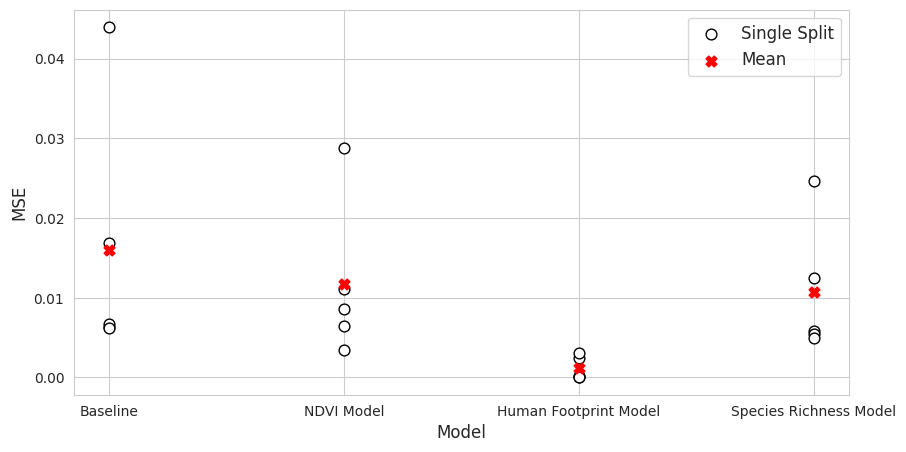

In [17]:
critter_test(wolf_data)

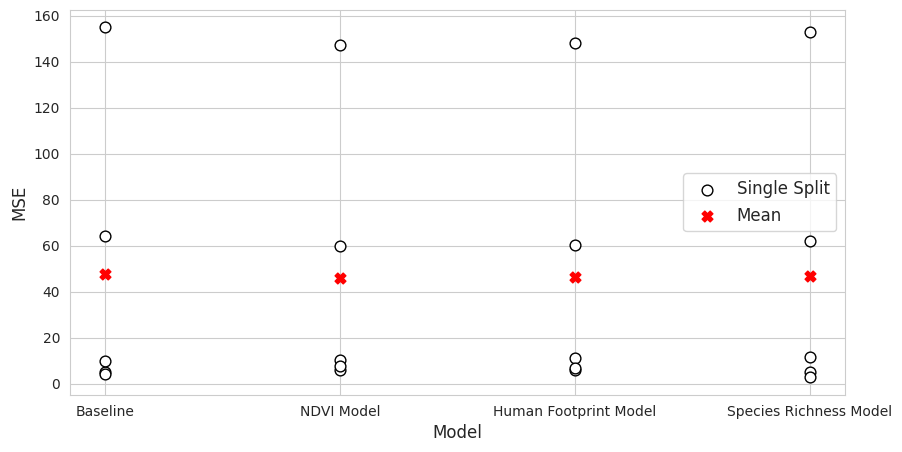

In [18]:
critter_test(fox_data)

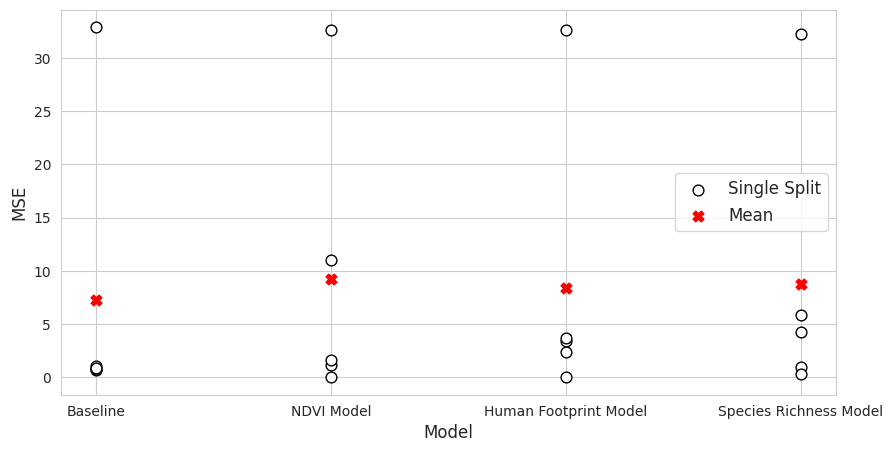

In [19]:
critter_test(coyote_data)

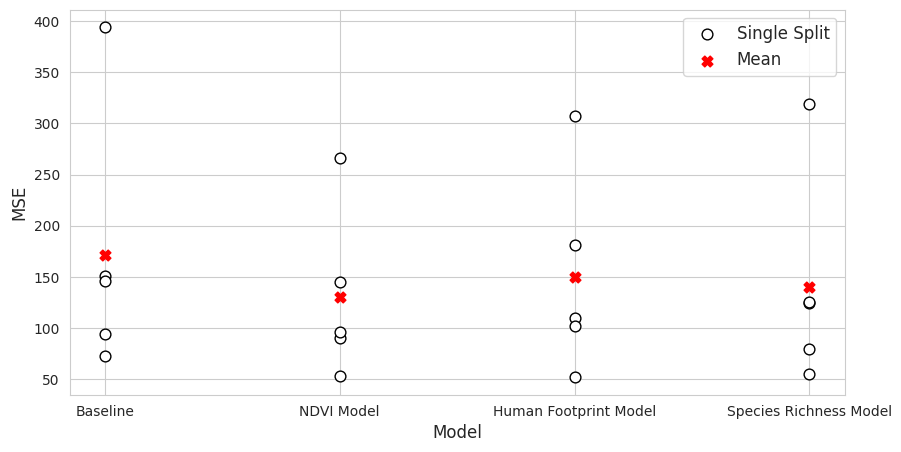

In [20]:
critter_test(badger_data)

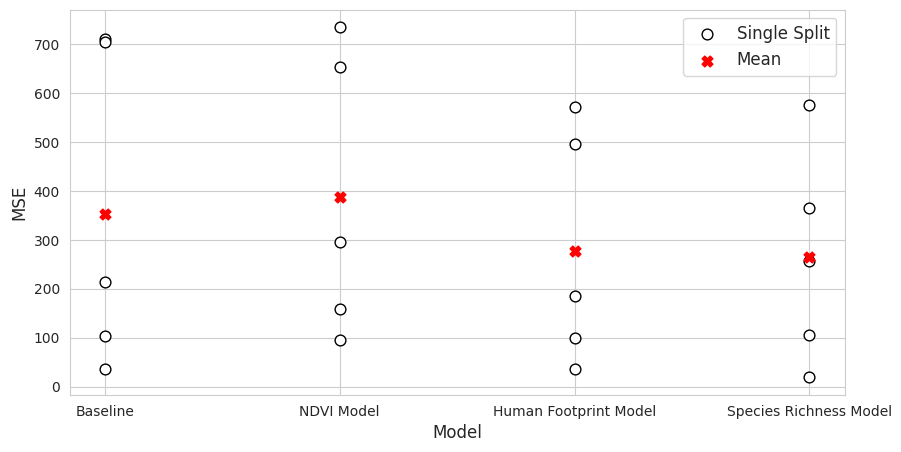

In [21]:
critter_test(langur_data)

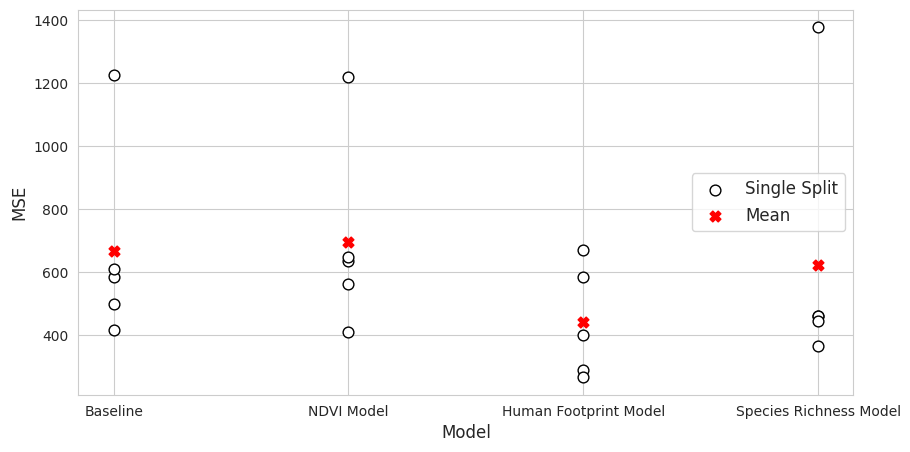

In [22]:
critter_test(raccoon_data)

For some species (wolf, raccoon), the Human Footprint Model performed a bit better than baseline, which matches our intuition (wolves avoid areas of human activity, while raccoons are common in urban areas).  For most of the species, the various linear regression models performed about the same or worse than the baseline.

In [30]:
raccoon_model = LinearRegression(copy_X=True)

In [31]:
raccoon_train, raccoon_test = train_test_split(raccoon_data.copy(),
                                        random_state = 919,
                                        shuffle = True,
                                        test_size=.2)

In [32]:
raccoon_model.fit(raccoon_train['Human Footprint_1deg'].values.reshape(-1,1), raccoon_train['Density (Ind/km2)'].values)

LinearRegression()

In [37]:
train_MSE = np.round(mean_squared_error(raccoon_train['Density (Ind/km2)'].values, raccoon_model.predict(raccoon_train['Human Footprint_1deg'].values.reshape(-1,1))),2)
test_MSE = np.round(mean_squared_error(raccoon_test['Density (Ind/km2)'].values, raccoon_model.predict(raccoon_test['Human Footprint_1deg'].values.reshape(-1,1))),2)

print("Training set RMSE:", 
      np.sqrt(train_MSE))

print("Test set RMSE:", 
      np.sqrt(test_MSE))

Training set RMSE: 19.632371227134026
Test set RMSE: 21.43968283347494


In [42]:
badger_model = LinearRegression(copy_X=True)

In [43]:
badger_train, badger_test = train_test_split(badger_data.copy(),
                                        random_state = 919,
                                        shuffle = True,
                                        test_size=.2)

In [44]:
badger_model.fit(badger_train['NDVI_1deg'].values.reshape(-1,1), badger_train['Density (Ind/km2)'].values)

LinearRegression()

In [45]:
train_MSE = np.round(mean_squared_error(badger_train['Density (Ind/km2)'].values, badger_model.predict(badger_train['NDVI_1deg'].values.reshape(-1,1))),2)
test_MSE = np.round(mean_squared_error(badger_test['Density (Ind/km2)'].values, badger_model.predict(badger_test['NDVI_1deg'].values.reshape(-1,1))),2)

print("Training set RMSE:", 
      np.sqrt(train_MSE))

print("Test set RMSE:", 
      np.sqrt(test_MSE))

Training set RMSE: 10.553198567259123
Test set RMSE: 10.4484448603608
